In [1]:
#This program finds homography points after locating the 4 QR codes (and each of their 4 corners) in the corners of the screen. 

#Questions:
#Order of QR corner readout
#Look at barcode.polygon elements

#Good videos to watch on this subject.
#https://www.youtube.com/watch?v=SrZuwM705yE
#https://www.youtube.com/watch?v=-4MPtERPq2E

In [2]:
# import the necessary packages
import cv2
import numpy as np
from pyzbar.pyzbar import decode
from matplotlib import pyplot as plt
import random

from skimage.transform import ProjectiveTransform
from skimage.io import imread

In [3]:
#Function that changes the color channels from OpenCV to Matplotlib for display purposes
# b/c .imshow doesn't work in Jupyter Notebooks.

def show_with_matplotlib(img, title):
    #Shows an image using matplotlib capabilities

    # Convert BGR image to RGB
    img_RGB = img[:, :, ::-1]

    # Show the image using matplotlib:
    plt.imshow(img_RGB)
    plt.title(title)
    plt.show()

In [8]:
#Read in images, change to correct dir later and create a loop to read in all images in a data set.

img = cv2.imread("C:/Users/JAZ/github/Starfitter21/Test_Images/20210127_133346.jpg")
#img = cv2.imread("C:/Users/JAZ/github/Starfitter21/Test_Images/20210127_133419.jpg")
#img = cv2.imread("C:/Users/JAZ/github/Starfitter21/Test_Images/20210128_111202.jpg")
#img = cv2.imread("C:/Users/JAZ/github/Starfitter21/Test_Images/20180920_00_0_25_0001QR.png")

In [4]:
#Sets counter for QR corners, to check to see if it found 16.

MIN_MATCH_COUNT = 0

xm = 0
ym = 0

In [5]:
#Screen information, in mm ("True Coordinates"), upper-left corner is origin. Order: UL, LL, UR, LR "Destination"
#upper edge of screen is horizontal, lower-left corner is negative because it's not perfectly rectangular

ScreenCornersmm = np.array([[0.0,0.0],[-2.8,616.5],[746.6,0.0],[745.8,615.8]],np.float32)

ScreenCornerspx = np.array([[0,0],[50,800],[1200,200],[1500,1200]],np.int32)

#Finds homography matrix (H) and the mask (inliers and outliers).
H, mask = cv2.findHomography(ScreenCornerspx, ScreenCornersmm, cv2.RANSAC,5.0)

In [6]:
#QR Code Coordinates in mm in relation to screen UL, LL, UR, LR

QRCornersmm = np.array([[10.7,7.7],[6.9,536.6],[675.2,9.5],[675.9,541.3],
                     [12.7,68.6],[7.1,603.3],[673.6,68.8],[674.6,600.7],
                     [71.5,5.3],[66.1,543.7],[734.6,11.2],[735.2,542.6],
                     [73.6,66.7],[66.5,603.2],[732.7,70.7],[733.9,602.0]],np.float32)

In [7]:
#bogus entries

QRCornerspx = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],np.int32)
    
#QRCornerspx will be decoded QR corners, below.

In [9]:
#Gets x,y coordinates of QR code. Use print(code) later to print garbled paragraph of info.
code = decode(img)

#Tells us the position and the size of the QR code.
#   print(barcode.rect) gives left value,top value, width, and height of bounding box
#print(barcode.polygon) = gives coordinates of QR corners

In [10]:
for barcode in decode(img):
    #Decodes barcode and converts it into a string)
    myData = barcode.data.decode('utf-8')

  
    #Puts polygon coordinates of QR code in np.array named pts.
    pts = np.array([barcode.polygon],np.int32)
    print("pts.shape:", pts.shape)
    print("QRCornerspx.shape", QRCornerspx.shape)

    #Computer average x and y of QR Code coordinates. 
    xm = (pts[0][0][0] + pts[0][1][0] + pts[0][2][0] + pts[0][3][0]) / 4
    ym = (pts[0][0][1] + pts[0][1][1] + pts[0][2][1] + pts[0][3][1]) / 4

    #Determine which QR coordinates are UL, LL, UR, and LR
    offset = -1
    
    if myData.find('upper-left') > -1: #lowercase because that's how the barcode was formed.
        offset = 0
        print("UL barcode found.")
        
    if myData.find('Lower-left') > -1:
        offset = 4
        print("LL barcode found.")
        
    if myData.find('Upper-right') > -1:
        offset = 8
        print("UR barcode found.")
        
    if myData.find('Lower-right') > -1:
        offset = 12
        print("LR barcode found.")
        
    if offset < 0:
        print("Foreign QR Code found.")
        continue
        
    for i in range(4):
           
        #x and y coordinates of the first point of the barcode read in.
        #We don't know which barcode corner it is yet.
        x = pts[0][i][0]
        y = pts[0][i][1] 
        
        
        if x < xm and y < ym:
            QRCornerspx[0 + offset] = pts[0][i] #UL corner of QR Code
            MIN_MATCH_COUNT = MIN_MATCH_COUNT + 1
            print("UL corner of QR Code found")
            continue
            
        if x < xm and y > ym:
            QRCornerspx[1 + offset] = pts[0][i] #LL corner of QR Code
            MIN_MATCH_COUNT = MIN_MATCH_COUNT + 1
            print("LL corner of QR Code found")
            continue
            
        if x > xm and y < ym:
            QRCornerspx[2 + offset] = pts[0][i] #UR corner of QR Code
            MIN_MATCH_COUNT = MIN_MATCH_COUNT + 1
            print("UR corner of QR Code found")
            continue
            
        if x > xm and y > ym:
            QRCornerspx[3 + offset] = pts[0][i] #LR corner of QR Code
            MIN_MATCH_COUNT = MIN_MATCH_COUNT + 1
            print("LR corner of QR Code found")
            continue
            
        print("Error. Point not found.") 


    #prints message of QR code and coordinate array of each.
    print("Message in Barcode:", myData)   
    print(QRCornerspx)
    print("\n")
    
    #Draws lines around polygon. True means it's a closed polygon, color, thickness.
    #"myData" in cv2.putText means that the QR message of that QR code is printed directly on the image.
    cv2.polylines(img,[pts],True,(255,0,0),3)
    pts2 = np.array([barcode.polygon],np.int32)
    cv2.putText(img, myData,(pts2[0][0][0],pts2[0][0][1]),cv2.FONT_HERSHEY_SIMPLEX, 1.3,(0,255,255),2)
    #cv2.putText(img, myData,(pts2[0][0][0],pts2[0][0][1]),cv2.FONT_HERSHEY_SIMPLEX, 0.9,(0,0,255),3)

#MIN_MATCH_COUNT check, to see if program found 16 corners
print(MIN_MATCH_COUNT)


pts.shape: (1, 4, 2)
QRCornerspx.shape (16, 2)
LL barcode found.
UL corner of QR Code found
LL corner of QR Code found
LR corner of QR Code found
UR corner of QR Code found
Message in Barcode: Lower-left corner of screen
[[   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [1529 1151]
 [1535 1246]
 [1609 1139]
 [1614 1232]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]]


pts.shape: (1, 4, 2)
QRCornerspx.shape (16, 2)
UR barcode found.
UL corner of QR Code found
LL corner of QR Code found
LR corner of QR Code found
UR corner of QR Code found
Message in Barcode: Upper-right corner of screen
[[   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [1529 1151]
 [1535 1246]
 [1609 1139]
 [1614 1232]
 [1480  271]
 [1482  370]
 [1561  273]
 [1563  371]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]]


pts.shape: (1, 4, 2)
QRCornerspx.shape (16, 2)
UL barcode found.
UL corner of QR Code found
LL corner of QR Code found
LR corner of QR 

In [11]:
#Homography Transform
H, mask = cv2.findHomography(QRCornerspx, QRCornersmm, cv2.RANSAC,5.0)
print(H)

print("Number of elements in pts:", len(pts))
print("Number of elements in QRCornerspx:", len(QRCornerspx))
#print("Code", code)

[[-4.37599281e-03  5.06086840e-02 -3.07473173e+00]
 [-5.32785639e-03  4.86999206e-02 -4.91930945e+00]
 [-6.56694000e-04  1.11438280e-04  1.00000000e+00]]
Number of elements in pts: 1
Number of elements in QRCornerspx: 16


In [12]:
# img.shape will return the dimensions of the image in a tuple like this: (99, 82, 3)
(h, w, c) = img.shape

# Now, we can print these three variables
# Print (h, w, c) values:

print("Dimensions of the image - Height: {}, Width: {}, Channels: {}".format(h, w, c))
# This will print 'Dimensions of the image - Height: 99, Width: 82, Channels: 3'

#Keep height and width, drop channels
img_size = (h, w)


Dimensions of the image - Height: 1747, Width: 1963, Channels: 3


In [ ]:
https://subscription.packtpub.com/book/data/9781789537147/1/ch01lvl1sec05/applying-perspective-transformation-and-homography
#im_src = (imread('images/humming2.png'))
height, width, dim = img.shape
im_dst = np.zeros((height, width, dim))
pt = ProjectiveTransform()
src = np.array([[ 295., 174.],
 [ 540., 146. ],
 [ 400., 777.],
 [ 60., 422.]])
dst = np.array([[ 0., 0.],
 [height-1, 0.],
 [height-1, width-1],
 [ 0., width-1]])
x, y = np.mgrid[:height, :width]
dst_indices = np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) 
src_indices = np.round(pt.inverse(dst_indices), 0).astype(int)
valid_idx = np.where((src_indices[:,0] < height) & (src_indices[:,1] < width) & 
                    (src_indices[:,0] >= 0) & (src_indices[:,1] >= 0))
dst_indicies_valid = dst_indices[valid_idx]
src_indicies_valid = src_indices[valid_idx]
im_dst[dst_indicies_valid[:,0],dst_indicies_valid[:,1]] =       
                                    im_src[src_indicies_valid[:,0],src_indicies_valid[:,1]]

In [13]:
# cv2.getPerspectiveTransform() needs four pairs of points
# (coordinates of a quadrangle in both the source and output image)
# We create the arrays for these four pairs of points:

#pts_1 = np.float32([[450, 65], [517, 65], [431, 164], [552, 164]])
#pts_2 = np.float32([[0, 0], [300, 0], [0, 300], [300, 300]])

# To correct the perspective (also known as perspective transformation) you need to create the transformation matrix
# making use of the function cv2.getPerspectiveTransform(), where a 3x3 matrix is constructed:
#M = cv2.getPerspectiveTransform(pts_1, pts_2)

In [14]:
# Resize the input image using cv2.resize()
# Resize using the scaling factor for each dimension of the image
# In this case the scaling factor is 0.5 in every dimension
#resizedimg = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)

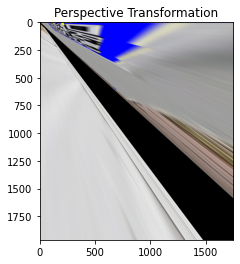

In [15]:
# Then, apply cv2.warpPerspective(), where the source image is transformed applying
# the specified matrix and with a specified size:
Himg = cv2.warpPerspective(img, H, img_size, flags=cv2.INTER_CUBIC) 

# Show the image:
show_with_matplotlib(Himg, 'Perspective Transformation')

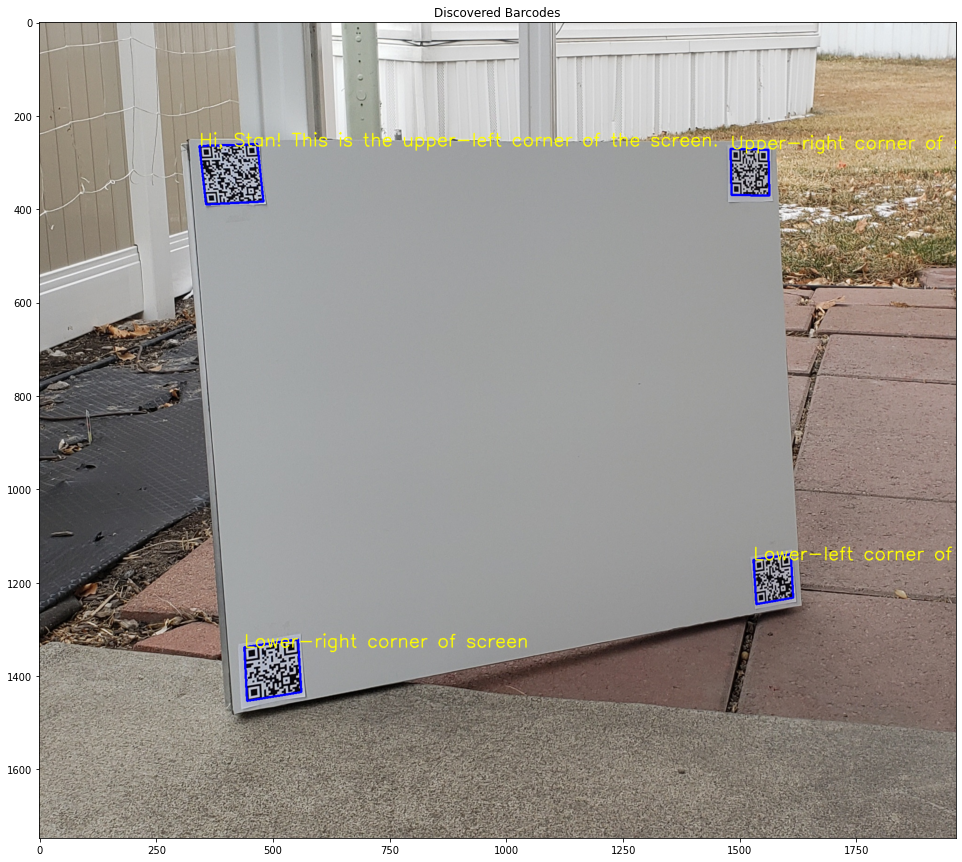

In [16]:
#Creates plot of original image, resized for visibility here.
plt.rcParams["figure.figsize"] = (20,15)

# Show loaded image:
show_with_matplotlib(img, 'Discovered Barcodes')

#plt.imshow(img),plt.show()
#cv2.imshow("Image", img)
#cv2.waitKey(0) #Don't use .waitKey with Jupyter notebooks
#cv2.destroyAllWindows()